In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sdebridge import diffusion_bridge as db
from sdebridge.sde import fourier_gaussian_kernel_sde, reverse
from sdebridge.utils import score_fn
from sdebridge.data_processing import sample_ellipse, butterfly2_pts

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [3]:
T=1.
N=50
dim=2
num_bases = 8
alpha = 1.0
sigma = 0.1
n_grid = 64
grid_range = (-1.5, 1.5)
n_samples = 100

In [4]:
def fourier_coefficients(array, num_bases):
    """Array of shape [..., pts, dim]
    Returns array of shape [..., :2*num_bases, dim]"""

    complex_coefficients = jnp.fft.rfft(array, norm="forward", axis=-2)[..., :num_bases, :]
    coeffs = jnp.stack([complex_coefficients.real, complex_coefficients.imag], axis=0)
    coeffs = coeffs.reshape(*complex_coefficients.shape[:-2], -1, complex_coefficients.shape[-1])
    return coeffs

def inverse_fourier(coefficients, num_pts):
    """Array of shape [..., 2*num_bases, dim]
    Returns array of shape [..., num_pts, dim]"""
    assert coefficients.shape[-2] % 2 == 0
    num_bases = int(coefficients.shape[-2] / 2)
    coeffs_real = coefficients[..., :num_bases, :]
    coeffs_im = coefficients[..., num_bases:, :]
    complex_coefficients = coeffs_real + 1j * coeffs_im
    return jnp.fft.irfft(complex_coefficients, norm="forward", n=num_pts, axis=-2)

In [5]:
# ellipse coefficients
ellipse_pts = sample_ellipse(200, scale=0.5, shifts=jnp.asarray([0.5, 0.5]))
ellipse_coeffs = fourier_coefficients(ellipse_pts, num_bases)

In [6]:
initial_butterfly = jnp.load('../data/tom_pts.npy')
target_butterfly = jnp.load('../data/honrathi_pts.npy')
print("initial_butterfly.shape", initial_butterfly.shape)
print("target_butterfly.shape", target_butterfly.shape)

initial_coeffs = fourier_coefficients(initial_butterfly, num_bases)
target_coeffs = fourier_coefficients(target_butterfly, num_bases)

initial_butterfly.shape (120, 2)
target_butterfly.shape (120, 2)


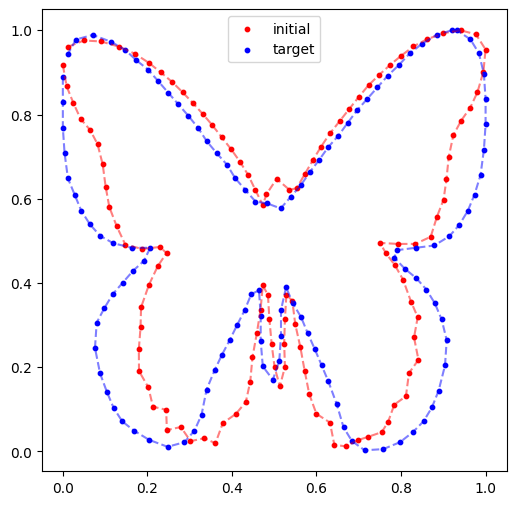

In [7]:
def plot_butterfly_pts(pts, ax, color='r', label=None):
    ax.scatter(pts[:, 0], pts[:, 1], color=color, label=label, s=10)
    ax.plot(pts[:, 0], pts[:, 1], color=color, alpha=0.5, linestyle='--')
    return ax

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = plot_butterfly_pts(initial_butterfly, ax, color='r', label='initial')
ax = plot_butterfly_pts(target_butterfly, ax, color='b', label='target')
ax.legend()
plt.show()

In [8]:
sde = fourier_gaussian_kernel_sde(T, N, dim, num_bases, alpha, sigma, n_grid, grid_range, n_samples)
key = jax.random.PRNGKey(2)

forward_trajs = sde.simulate_trajectories(initial_coeffs, 64, key)

In [9]:
import time

start_time = time.time()
for _ in range(10000):
    sde.diffusion(initial_coeffs, _)
end_time = time.time()
total = end_time-start_time
print(total)

3.7001900672912598


In [20]:
initial_vals = jnp.tile(initial_coeffs, reps=(256, 1, 1))

start_time = time.time()
db.euler_and_grad_and_cov(sde, initial_vals, key)
end_time = time.time()
total = end_time-start_time
print(total)

4.5850419998168945


In [24]:
start_time = time.time()
t = sde.simulate_trajectories(initial_coeffs, 512, key)
sde.grad_and_covariance(t)
end_time = time.time()
total = end_time-start_time
print(total)

54.42203712463379


In [10]:
initial_vals = jnp.tile(initial_coeffs, reps=(256, 1, 1))
trajs, grads, covs = db.euler_and_grad_and_cov(sde, initial_vals, key)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x103c55df0>>
Traceback (most recent call last):
  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
from sdebridge.plotting import plot_single_trajectory

forward_traj_coeffs = forward_trajs[0]
forward_traj = inverse_fourier(forward_traj_coeffs, 100)
traj = forward_traj.reshape((N, -1))
plot_single_trajectory(traj, "Unconditioned Kunita Flow")

In [ ]:
from sdebridge.networks.score_unet import ScoreUNet

import functools

net = ScoreUNet

network = {
    "output_dim": sde.dim*sde.n_bases,
    "time_embedding_dim": 32,
    "init_embedding_dim": 32,
    "act_fn": "silu",
    "encoder_layer_dims": [64, 32, 16, 8],
    "decoder_layer_dims": [8, 16, 32, 64],
    "batchnorm": True,
}
    
training = {
    "batch_size": 128,
    "load_size": 128,
    "num_epochs": 10,
    "learning_rate": 1e-3,
    "warmup_steps": 0,
}
target = ellipse_coeffs
train_key = jax.random.split(key, 2)[0]


score_p_state = db.learn_p_score(sde, target, train_key, **training, net=net, network_params=network)

In [ ]:
initial_pts = sample_ellipse(120, scale=1.0, shifts=jnp.array([0.5, 0.5]))
initial_coeffs = fourier_coefficients(initial_pts, num_bases)
print(initial_pts.shape)
print(initial_coeffs.shape)

reverse_sde = reverse(sde, score_fn(score_p_state))
backward_coeffs = reverse_sde.simulate_trajectories(initial_coeffs, 2, key)

forward_coeffs = sde.simulate_trajectories(initial_coeffs, 2, key)

In [ ]:
backward_traj = inverse_fourier(backward_coeffs[1], 100)
traj = backward_traj.reshape((N, -1))
plot_single_trajectory(traj, "Conditioned Brownian Motion")
target_plt = inverse_fourier(target, 50)
plt.scatter(target_plt[:, 0], target_plt[:, 1], c="b")

forward_traj = inverse_fourier(forward_coeffs[1], 100)
traj = forward_traj.reshape((N, -1))
plot_single_trajectory(traj, "Unconditioned Brownian Motion")

In [ ]:
plt_backward_coeffs = backward_coeffs[0]
print(backward_coeffs.shape)

for i, coeff in enumerate(range(2*num_bases)):
    plt.scatter(plt_backward_coeffs[-1, coeff, 0], plt_backward_coeffs[-1, coeff, 1], color=f"C{i}")
    plt.scatter(plt_backward_coeffs[0, coeff, 0], plt_backward_coeffs[0, coeff, 1], color=f"C{i}", marker="P")

    plt.plot(plt_backward_coeffs[:, coeff, 0], plt_backward_coeffs[:, coeff, 1], color=f"C{i}")
    plt.scatter(target[coeff, 0], target[coeff, 1], color=f"C{i}", marker="X")